In [1]:
import os
import matplotlib.pyplot as plt
import neurolib.optimize.exploration.explorationUtils as eu
import numpy as np
from neurolib.models.multimodel import MultiModel
from neurolib.models.multimodel.builder import HopfNetwork
from neurolib.optimize.exploration import BoxSearch
from neurolib.utils.functions import getPowerSpectrum
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.utils.stimulus import ZeroInput

import neurolib.utils.pypetUtils as pu
from scipy.signal import find_peaks

from hopf_cfc_network import SlowFastHopfNetwork
from cfcUtils import modulation_index

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

import h5py
import pandas as pd

plt.style.use("seaborn")
plt.rcParams['image.cmap'] = 'plasma'

# w instrinsic
# 0.003 ~ 0.5Hz
# 0.005 ~ 0.8Hz
# 0.01 ~ 2Hz
# 0.05 ~ 8Hz
# 0.06 ~ 10Hz
# 0.08 ~ 12Hz
# 0.1 ~ 17Hz
# 0.2 ~ 32Hz
# 0.3 ~ 50Hz

# intrinsic frequencies of SlowFastHopfNetwork are:
# slow intrinsic frequency ~ 6Hz
# fast intrinsic frequency ~ 30Hz

import warnings
warnings.filterwarnings("ignore")

In [2]:
DURATION = 20.0 * 1000  # ms
DT = 0.1  # ms

model = MultiModel(
    SlowFastHopfNetwork(
        number_of_slow_fast_units=1,
        slow_to_fast_connection=0.1,
        fast_to_slow_connection=0.05,
    )
)

model.params["duration"] = 20.0 * 1000
model.params["sampling_dt"] = DT
model.params["dt"] = 0.01  # ms - lower dt for numba backend
# numba backend is the way to go in exploration - much faster
model.params["backend"] = "numba"

# manually add params you want to change during exploration, btw model.params is just a dictionary, so you can add whatever :)
model.params["coupling"] = "multiplicative"

In [3]:
parameters = ParameterSpace(
    {
        "coupling":["additive","diffusive","multiplicative"]

    }
    ,allow_star_notation=True,
    kind="sequence",)

In [4]:
def evaluateSimulation(traj):
    # get model with parameters for this run
    model = search.getModelFromTraj(traj)
    # extract stuff you want
    coupling = model.params["coupling"]

    model.model_instance.default_coupling = {'network_x': coupling, 'network_y':coupling}

    model.run()

    n_bins = 18

    phase_slow = np.arctan2(model.y[0, :], model.x[0, :])
    amp_fast = np.sqrt(model.x[1, :] ** 2 + model.y[1, :] ** 2)
    binned_phase = np.digitize(phase_slow, bins=np.linspace(-np.pi, np.pi, n_bins + 1))
    mean_bin_amp = np.zeros(n_bins + 1)  # in theory index of bins goes from 0 to N_BINS
    for bin_idx in np.unique(binned_phase):
        mean_bin_amp[bin_idx] = np.mean(amp_fast[binned_phase == bin_idx])

    mean_bin_amp = mean_bin_amp[
        1:
    ]  # because in theory there could be stuff that is smaller than -pi, then actually the interval between -pi and the next bin has index 1.
    # normalize the mean amplitude in each bin
    mean_bin_amp = mean_bin_amp / np.sum(mean_bin_amp)
    mi = modulation_index(mean_bin_amp)

    freq_slow, pow_slow = getPowerSpectrum(model.x.T[:, 0], dt=0.1, maxfr=40, spectrum_windowsize=1)
    freq_fast, pow_fast = getPowerSpectrum(model.x.T[:, 1], dt=0.1, maxfr=40, spectrum_windowsize=1)


    peaks_fast, _ = find_peaks(pow_fast,height=max(1e-3, 1.0*np.std(pow_fast)))

    #set the height as ratio of std, we always want peaks that are bigger than 1std
    #one model, with 0.3 fast to slow, choose
    peaks_slow, _ = find_peaks(pow_slow,height=max(1e-3, 0.5*np.std(pow_slow)))


    result_dict = {"modulation_index": mi, "peaks_freq_fast": freq_fast[peaks_fast], "peaks_freq_slow": freq_slow[peaks_slow]}
    search.saveToPypet(result_dict, traj)

In [5]:
search = BoxSearch(
    model=model,
    evalFunction=evaluateSimulation,
    parameterSpace=parameters,
    filename="Hopf_1d_conn_test_wPeaks.hdf",
    ncores=6,
)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/Hopf_1d_conn_test_wPeaks.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 3
MainProcess root INFO     BoxSearch: Environment initialized.


In [6]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-05-27-11H-36M-42S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2022-05-27-11H-36M-42S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2022-05-27-11H-36M-42S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-05-27-11H-36M-42S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [7]:
search.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/Hopf_1d_conn_test_wPeaks.hdf
MainProcess root INFO     Analyzing trajectory results-2022-05-27-11H-36M-42S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/Hopf_1d_conn_test_wPeaks.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2022-05-27-11H-36M-42S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 3/3 [00:00<00:00, 168.83it/s]
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 3/3 [00:00<00:00, 688.61it/s]

In [8]:
search.dfResults

,coupling,peaks_freq_slow,peaks_freq_fast,modulation_index
0,additive,[12.0],"[12.0, 21.0]",1.257242e-06
1,diffusive,[13.0],[13.0],5.467905e-08
2,multiplicative,[6.0],[32.0],4.277516e-04


I now want to compare the time series, and see what was different

In [9]:
DURATION = 20.0 * 1000  # ms
DT = 0.1  # ms
def simulate(slow_to_fast_conn=0.1,fast_to_slow_conn=.05, frequency_fast = 0.2, frequency_slow = 0.04, coupling = "multiplicative"):
    model = MultiModel(
        SlowFastHopfNetwork(
            number_of_slow_fast_units=1,
            slow_to_fast_connection=slow_to_fast_conn,
            fast_to_slow_connection=fast_to_slow_conn,
        )
    )
    model.params["duration"] = 20.0 * 1000
    model.params["sampling_dt"] = DT
    model.params["dt"] = DT
    model.params['SlowFastHopfNet.SlowHopf_0.HopfMass_0.w'] = frequency_slow
    model.params['SlowFastHopfNet.FastHopf_1.HopfMass_0.w'] = frequency_fast

    model.model_instance.default_coupling = {'network_x': coupling, 'network_y':coupling}
    model.run()

    return model

MainProcess root INFO     Initialising jitcdde backend...
MainProcess root INFO     Setting up the DDE system...
MainProcess root INFO     Compiling to C...
/tmp/tmprzmnxnhq/jitced_1.c: In function ‘get_past_anchors’:
/tmp/tmprzmnxnhq/jitced_1.c:176: warning: ignoring #pragma omp atomic [-Wunknown-pragmas]
  176 |  #pragma omp atomic capture
      | 
/tmp/tmprzmnxnhq/jitced_1.c:190: warning: ignoring #pragma omp critical [-Wunknown-pragmas]
  190 |   #pragma omp critical(pws)
      | 
/tmp/tmprzmnxnhq/jitced_1.c: In function ‘get_recent_state’:
/tmp/tmprzmnxnhq/jitced_1.c:285: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
  285 |  #pragma omp parallel for schedule(dynamic, 1)
      | 
In file included from /tmp/tmprzmnxnhq/jitced_1.c:370:
/tmp/tmprzmnxnhq/f.c: In function ‘eval_f’:
/tmp/tmprzmnxnhq/f.c:1: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
    1 | #pragma omp parallel sections
      | 
/tmp/tmprzmnxnhq/f.c:3: warning: ignoring #pragma omp section [-

Using default integration parameters.


MainProcess root INFO     Integrating for 200000 time steps...
100%|██████████| 200000/200000 [00:00<00:00, 326316.74it/s]
MainProcess root INFO     Integration done.
MainProcess root INFO     `run` call took 18.08 s


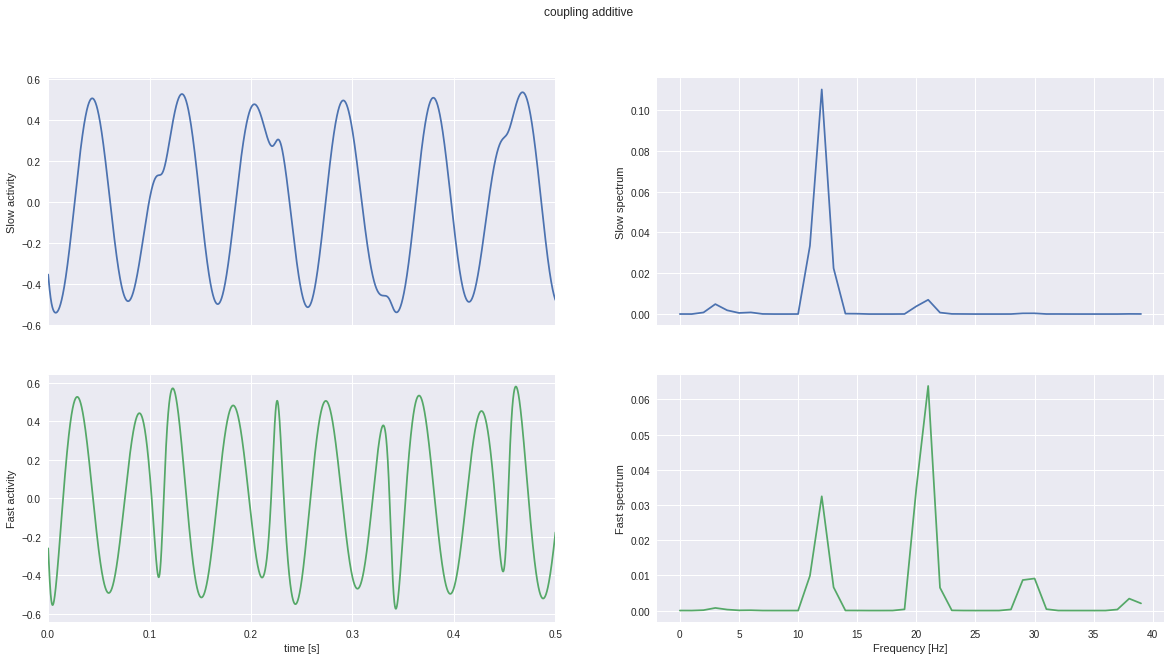

MainProcess root INFO     SlowFastHopfNet: Model initialized.
MainProcess root INFO     Initialising jitcdde backend...
MainProcess root INFO     Setting up the DDE system...
MainProcess root INFO     Compiling to C...
/tmp/tmp2byzqxjz/jitced_2.c: In function ‘get_past_anchors’:
/tmp/tmp2byzqxjz/jitced_2.c:176: warning: ignoring #pragma omp atomic [-Wunknown-pragmas]
  176 |  #pragma omp atomic capture
      | 
/tmp/tmp2byzqxjz/jitced_2.c:190: warning: ignoring #pragma omp critical [-Wunknown-pragmas]
  190 |   #pragma omp critical(pws)
      | 
/tmp/tmp2byzqxjz/jitced_2.c: In function ‘get_recent_state’:
/tmp/tmp2byzqxjz/jitced_2.c:285: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
  285 |  #pragma omp parallel for schedule(dynamic, 1)
      | 
In file included from /tmp/tmp2byzqxjz/jitced_2.c:370:
/tmp/tmp2byzqxjz/f.c: In function ‘eval_f’:
/tmp/tmp2byzqxjz/f.c:1: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
    1 | #pragma omp parallel sections
      | 
/t

Using default integration parameters.


MainProcess root INFO     Integrating for 200000 time steps...
100%|██████████| 200000/200000 [00:00<00:00, 348429.09it/s]
MainProcess root INFO     Integration done.
MainProcess root INFO     `run` call took 17.57 s


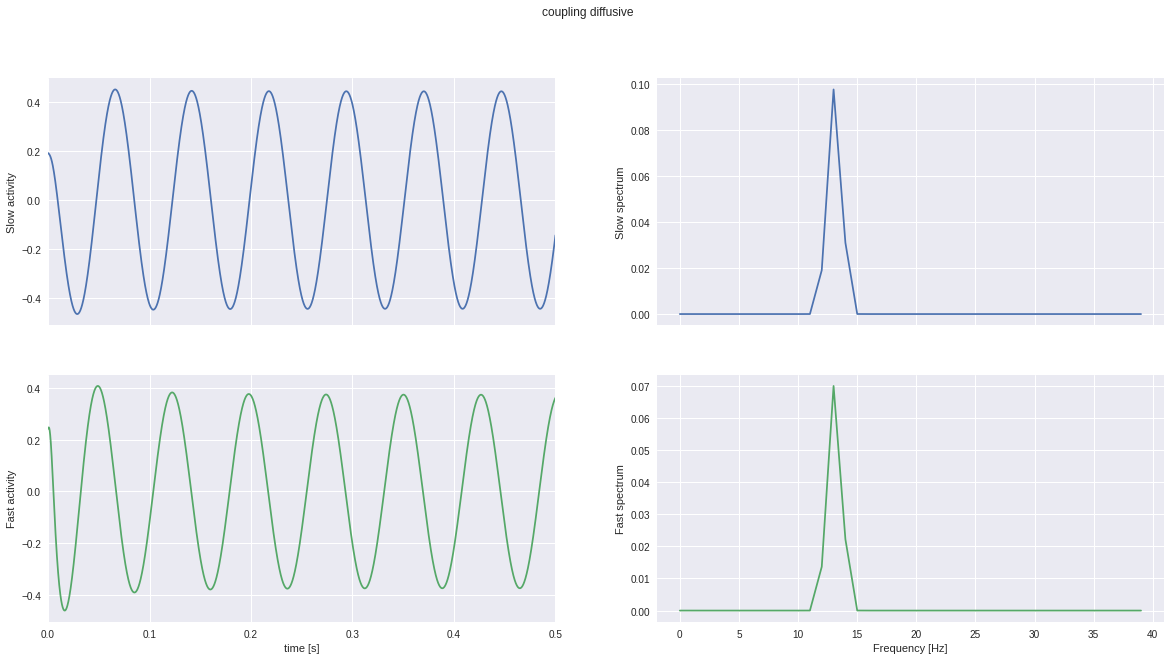

MainProcess root INFO     SlowFastHopfNet: Model initialized.
MainProcess root INFO     Initialising jitcdde backend...
MainProcess root INFO     Setting up the DDE system...
MainProcess root INFO     Compiling to C...
/tmp/tmpzh3q97si/jitced_3.c: In function ‘get_past_anchors’:
/tmp/tmpzh3q97si/jitced_3.c:176: warning: ignoring #pragma omp atomic [-Wunknown-pragmas]
  176 |  #pragma omp atomic capture
      | 
/tmp/tmpzh3q97si/jitced_3.c:190: warning: ignoring #pragma omp critical [-Wunknown-pragmas]
  190 |   #pragma omp critical(pws)
      | 
/tmp/tmpzh3q97si/jitced_3.c: In function ‘get_recent_state’:
/tmp/tmpzh3q97si/jitced_3.c:285: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
  285 |  #pragma omp parallel for schedule(dynamic, 1)
      | 
In file included from /tmp/tmpzh3q97si/jitced_3.c:370:
/tmp/tmpzh3q97si/f.c: In function ‘eval_f’:
/tmp/tmpzh3q97si/f.c:1: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
    1 | #pragma omp parallel sections
      | 
/t

Using default integration parameters.


MainProcess root INFO     Integrating for 200000 time steps...
100%|██████████| 200000/200000 [00:00<00:00, 312652.88it/s]
MainProcess root INFO     Integration done.
MainProcess root INFO     `run` call took 18.02 s


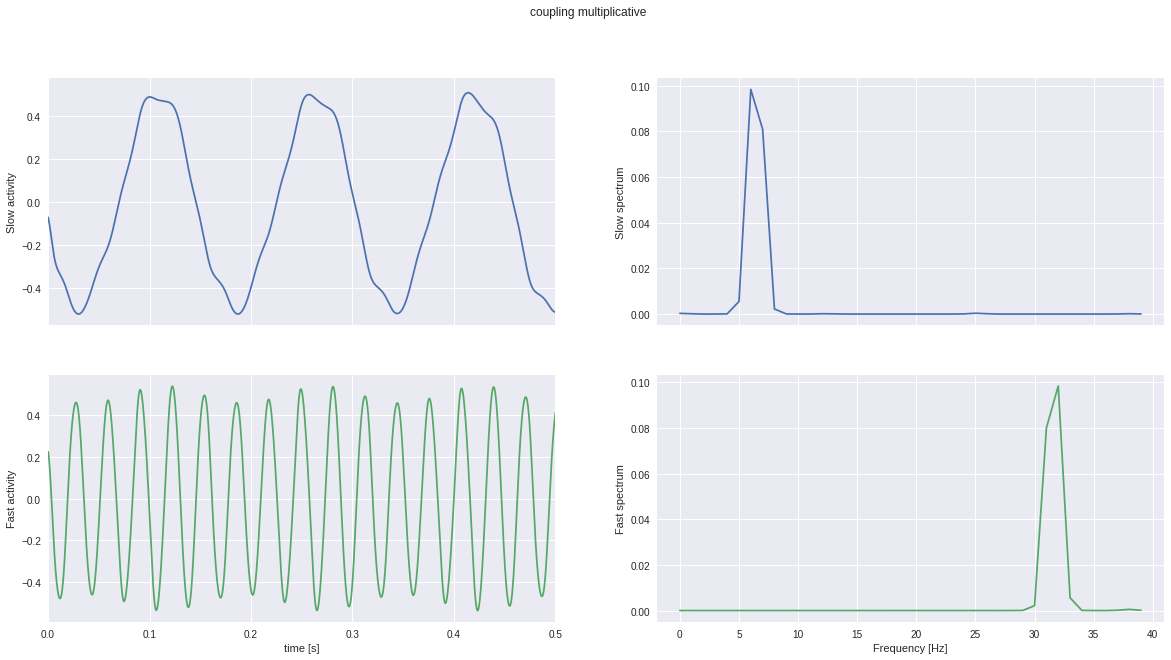

MainProcess root INFO     SlowFastHopfNet: Model initialized.
MainProcess root INFO     Initialising jitcdde backend...
MainProcess root INFO     Setting up the DDE system...
MainProcess root INFO     Compiling to C...
/tmp/tmprwq7tgw8/jitced_4.c: In function ‘get_past_anchors’:
/tmp/tmprwq7tgw8/jitced_4.c:176: warning: ignoring #pragma omp atomic [-Wunknown-pragmas]
  176 |  #pragma omp atomic capture
      | 
/tmp/tmprwq7tgw8/jitced_4.c:190: warning: ignoring #pragma omp critical [-Wunknown-pragmas]
  190 |   #pragma omp critical(pws)
      | 
/tmp/tmprwq7tgw8/jitced_4.c: In function ‘get_recent_state’:
/tmp/tmprwq7tgw8/jitced_4.c:285: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
  285 |  #pragma omp parallel for schedule(dynamic, 1)
      | 
In file included from /tmp/tmprwq7tgw8/jitced_4.c:370:
/tmp/tmprwq7tgw8/f.c: In function ‘eval_f’:
/tmp/tmprwq7tgw8/f.c:1: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
    1 | #pragma omp parallel sections
      | 
/t

Using default integration parameters.


MainProcess root INFO     Integrating for 200000 time steps...
100%|██████████| 200000/200000 [00:00<00:00, 330216.87it/s]
MainProcess root INFO     Integration done.
MainProcess root INFO     `run` call took 17.55 s


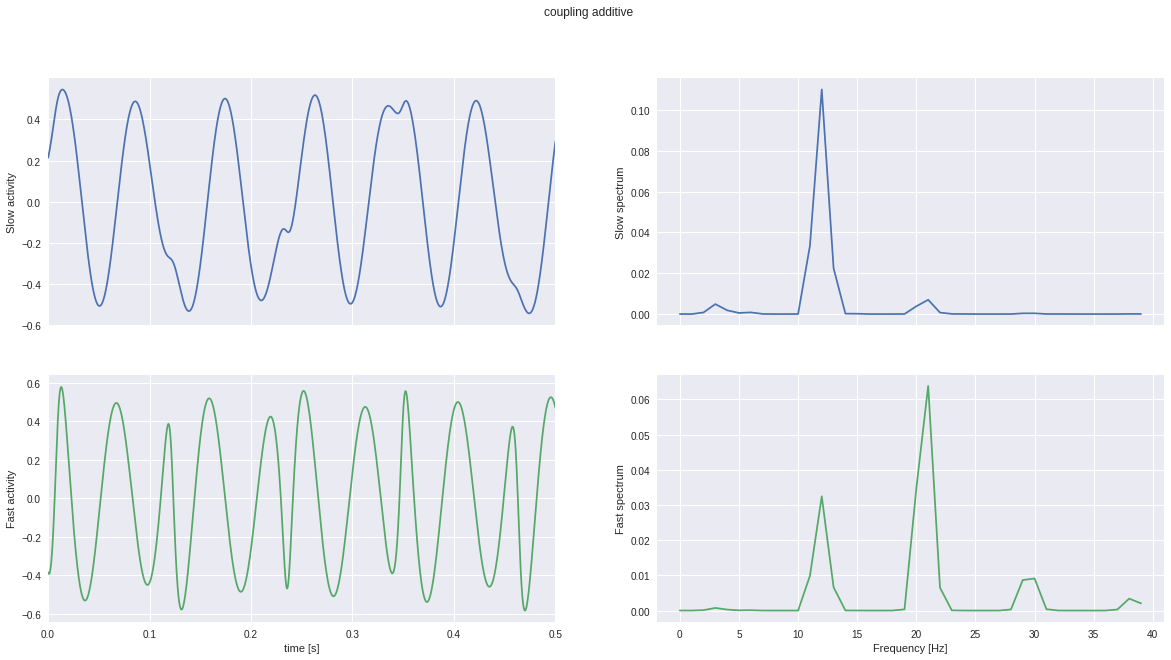

MainProcess root INFO     SlowFastHopfNet: Model initialized.
MainProcess root INFO     Initialising jitcdde backend...
MainProcess root INFO     Setting up the DDE system...
MainProcess root INFO     Compiling to C...
/tmp/tmped85osud/jitced_5.c: In function ‘get_past_anchors’:
/tmp/tmped85osud/jitced_5.c:176: warning: ignoring #pragma omp atomic [-Wunknown-pragmas]
  176 |  #pragma omp atomic capture
      | 
/tmp/tmped85osud/jitced_5.c:190: warning: ignoring #pragma omp critical [-Wunknown-pragmas]
  190 |   #pragma omp critical(pws)
      | 
/tmp/tmped85osud/jitced_5.c: In function ‘get_recent_state’:
/tmp/tmped85osud/jitced_5.c:285: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
  285 |  #pragma omp parallel for schedule(dynamic, 1)
      | 
In file included from /tmp/tmped85osud/jitced_5.c:370:
/tmp/tmped85osud/f.c: In function ‘eval_f’:
/tmp/tmped85osud/f.c:1: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
    1 | #pragma omp parallel sections
      | 
/t

In [10]:
coupling = ["multiplicative","additive","diffusive"]
for c in coupling:
    model = simulate(coupling = c)
    _, axs = plt.subplots(nrows=2, ncols=2, sharex="col", figsize=(20, 10))

    axs[0, 0].plot(model.t, model.x.T[:, 0])
    axs[0, 0].set_ylabel("Slow activity")
    axs[1, 0].plot(model.t, model.x.T[:, 1], color="C1")
    axs[1, 0].set_ylabel("Fast activity")
    axs[1, 0].set_xlabel("time [s]")
    freq_slow, pow_slow = getPowerSpectrum(model.x.T[:, 0], dt=0.1, maxfr=40, spectrum_windowsize=1)
    axs[0, 1].plot(freq_slow, pow_slow)
    axs[0, 1].set_ylabel("Slow spectrum")
    freq_fast, pow_fast = getPowerSpectrum(model.x.T[:, 1], dt=0.1, maxfr=40, spectrum_windowsize=1)
    axs[1, 1].plot(freq_fast, pow_fast, color="C1")
    axs[1, 1].set_ylabel("Fast spectrum")
    axs[1, 1].set_xlabel("Frequency [Hz]")

    axs[0, 0].set_xlim([0, 0.5])
    plt.suptitle(f"coupling {c}")
    plt.show()